**Cladocopium from Acropora cf tenuis samples in the central Philippines - PCA, etc**

Inputs:\
Eigenvectors and eigenvalues created with Plink2 PCA\
Lists of sample names belonging to differing cryptic Acropora taxa\
Cluster evaluation with DFA\
Created by Jaelyn Bos, May 2025

In [26]:
#Make sure R can find packages installed through Conda
.libPaths('/hb/home/jbos/.conda/envs/vcfR')
.libPaths("/hb/home/jbos/.conda/envs/vcfR/lib/R/library")
#.libPaths('/hb/software/apps/r/conda3-4.4.1/lib/R/library')|
#.libPaths('/hb/home/jbos/R/x86_64-conda-linux-gnu-library/4.4')

In [27]:
#Load packages
library(tidyverse)
library(vcfR)
library(hierfstat)
library(adegenet)
library(poppr)
library(cowplot)
library(ggh4x)

In [28]:
#Import Cladocopium SNP data in vcf form and convert to genind
vcf<-read.vcfR("/hb/scratch/jbos/cladocopium/vcf_thinned500bp.recode.vcf")
gi <- vcfR2genind(vcf)

Scanning file to determine attributes.
File attributes:
  meta lines: 6904
  header_line: 6905
  variant count: 819
  column count: 319
Meta line 6904 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 819
  Character matrix gt cols: 319
  skip: 0
  nrows: 819
  row_num: 0
Processed variant: 819
All variants processed


Choose the number of clusters (>=2): 

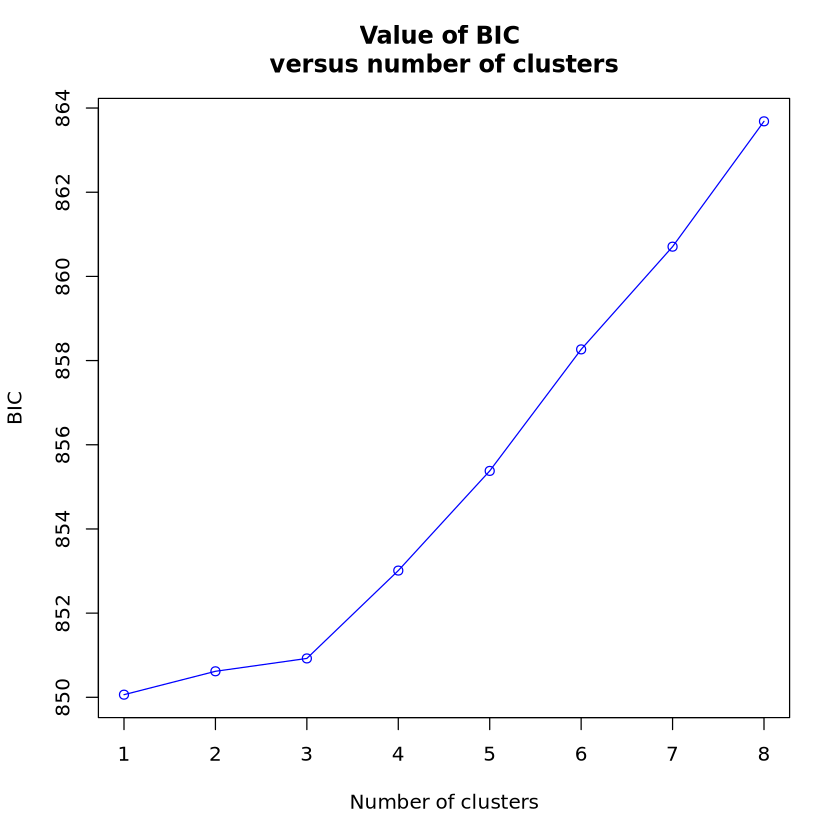

In [29]:
#Use DFA to compare different numbers of genetic clusters by BIC
grp_clad<-find.clusters(gi,max.n.clust=8,n.pca=500)

In [30]:
#Read in ADMIXTURE out files, plus create a vector of individual names
ind_tab<-read.table('/hb/scratch/jbos/cladocopium/cladocopium_500bp_int_thinned.fam')
ind_names<-paste(ind_tab[,1],'_',ind_tab[,2],sep="")
admix_tab<-read.table('/hb/scratch/jbos/cladocopium/cladocopium_500bp_int_thinned.5.Q')
colnames(admix_tab)<-c('grp1','grp2','grp3','grp4','grp5')

In [31]:
#Add sample names to ADMIXTURE table
admix_tab<-cbind(ind_names,admix_tab)

In [32]:
#Import names of individuals samples assigned to each Acropora cryptic taxon
taxa1<-read_csv('taxa1_inds.csv',show_col_types = FALSE)$x
taxa2<-read_csv('taxa2_inds.csv',show_col_types = FALSE)$x
taxa3<-read_csv('taxa3_inds.csv',show_col_types = FALSE)$x
taxa4<-read_csv('taxa4_inds.csv',show_col_types = FALSE)$x

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


In [33]:
#Add Acropora taxa variable 
admix_tab$Acropora_taxa<-0
admix_tab$Acropora_taxa[admix_tab$ind_names %in% taxa1] <-1
admix_tab$Acropora_taxa[admix_tab$ind_names %in% taxa2] <-2
admix_tab$Acropora_taxa[admix_tab$ind_names %in% taxa3] <-3
admix_tab$Acropora_taxa[admix_tab$ind_names %in% taxa4] <-4
table(admix_tab$Acropora_taxa)


  0   1   2   3   4 
 14 113  73  49  61 

In [34]:
#Sort table by Acropora taxa variable
admix_tab<-admix_tab[order(admix_tab$Acropora_taxa),]

In [35]:
#Move data to long format for graphing because ggplot secretly wants to be Microsoft Excel
admix_long<-pivot_longer(admix_tab,cols=c('grp1','grp2','grp3','grp4','grp5'),names_to='group')

In [36]:
#Import eigenvectors and eigenvalues previously created with Plink2
eigenval <- read.table("/hb/scratch/jbos/cladocopium/pca_500bp.eigenval", header = FALSE, sep = " ")
eigenvec <- read.table("/hb/scratch/jbos/cladocopium/pca_500bp.eigenvec", header = FALSE, sep = "\t")
colnames(eigenvec)<-c('Sample_ID','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')

In [37]:
#Calculate the % of variation represented by each principal component
varPC1 <- (eigenval[1,1] / sum(eigenval$V1))*100
varPC2 <- (eigenval[2,1] / sum(eigenval$V1))*100
varPC3 <- (eigenval[3,1] / sum(eigenval$V1))*100

varPC1
varPC2
varPC3

[1] 16.88502

[1] 14.96345

[1] 12.769

In [38]:
#Add Acropora taxon variable to eigenvector dataset
eigenvec$Taxon<-'Unassigned'
eigenvec$Taxon[eigenvec$Sample_ID %in% taxa1]<-"Taxa1"
eigenvec$Taxon[eigenvec$Sample_ID %in% taxa2]<-"Taxa2"
eigenvec$Taxon[eigenvec$Sample_ID %in% taxa3]<-"Taxa3"
eigenvec$Taxon[eigenvec$Sample_ID %in% taxa4]<-"Taxa4"

In [39]:
#Assign a color to each Acropora taxon
taxa_colors <- c("Taxa1" = "#440154FF","Taxa2" = "#31688EFF","Taxa3" = "#35B779FF","Taxa4" = "#FDE725FF",'Unassigned' = "#000000")

Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


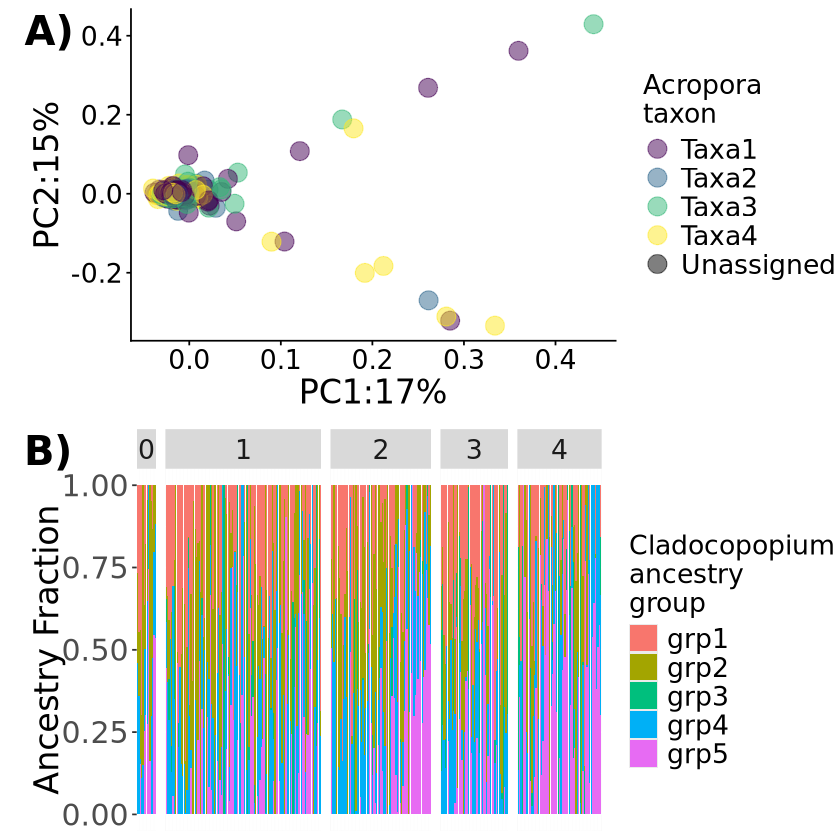

In [40]:
#Make combined PCA and ADMIXTURE plot
p1 <- ggplot(eigenvec, aes(x=PC1, y=PC2, color=Taxon)) +
  geom_point(shape=19, size=5, alpha=0.5) +
  theme_classic() +
  scale_color_manual(name='Acropora \ntaxon', values = taxa_colors) +
  theme(
    plot.title = element_text(size = 24),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20))+
  labs(color = "Taxon", x = "PC1:17%", y = "PC2:15%")

adplot <- ggplot(admix_long, aes(x = ind_names, y = value, fill = group)) +
  geom_col(position = position_fill()) +
  facet_grid(. ~ Acropora_taxa, scales = "free_x", space = "free_x") +
  ylab("Ancestry Fraction") +
  labs(fill = "Cladocopopium \nancestry \ngroup") +
  theme(
    plot.title = element_text(size = 18),
    axis.title.y = element_text(size = 20),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 18),
    axis.title.x = element_blank(),
    axis.ticks.x = element_blank(),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16),
    strip.text = element_text(size = 16)
  )

p1_adj <- p1 + theme(plot.margin = margin(5.5, 5.5, 5.5, 20, unit = "pt"))
adplot_adj <- adplot + theme(plot.margin = margin(5.5, 5.5, 5.5, 20, unit = "pt"))

combined <- plot_grid(
  p1_adj, adplot_adj,
  labels = c("A)", "B)"),
  label_size = 24,
  ncol = 1,
  align = "v"
)

ggsave("cladocopium_clusters.png", combined, width = 8, height = 8, dpi = 1200, units = "in")

combined

In [41]:
#Check % of individuals with >7/8 of ancestry coming form same group
table(apply(admix_tab[,2:6],MARGIN=1,FUN=max)<=0.875)
23/310

#Check % of individuals with >1/2 of ancestry coming form same group
table(apply(admix_tab[,2:6],MARGIN=1,FUN=max)<=0.5)
204/310


FALSE  TRUE 
   23   287 

[1] 0.07419355


FALSE  TRUE 
  204   106 

[1] 0.6580645

In [42]:
#Create 'island' (Cebu vs. Leyte) and 'population' (site) variables by splitting sample names. This will be used for later analysis and plotting. 
eigenvec$Island <- substr(eigenvec$Sample_ID,start=1,stop=3)
eigenvec$Pop <- substr(eigenvec$Sample_ID,start=1,stop=5)

In [43]:
#Read in metadata for individual samples with calculated distance to shore
metadat<-read.csv('metadata_shoredist.csv')

In [44]:
#Join metadata and eigenvector data. Note that not all individuals have associated metadata; these individuals are dropped
metadat_merge<-left_join(eigenvec,metadat)

Joining with `by = join_by(Sample_ID)`


In [45]:
#Check for singificant linear relationshiph between depth and any of the first four PCs for all Cladocopium
summary(lm(PC1 ~ Depth_ft, data=metadat_merge))
summary(lm(PC2 ~ Depth_ft, data=metadat_merge))
summary(lm(PC3 ~ Depth_ft, data=metadat_merge))
summary(lm(PC4 ~ Depth_ft, data=metadat_merge))


Call:
lm(formula = PC1 ~ Depth_ft, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09846 -0.02688 -0.01388  0.00573  0.43708 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.056801   0.017316  -3.280 0.001408 ** 
Depth_ft     0.004716   0.001275   3.699 0.000346 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07023 on 105 degrees of freedom
  (203 observations deleted due to missingness)
Multiple R-squared:  0.1153,	Adjusted R-squared:  0.1069 
F-statistic: 13.68 on 1 and 105 DF,  p-value: 0.0003461



Call:
lm(formula = PC2 ~ Depth_ft, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33250 -0.00728  0.00058  0.01035  0.42656 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.024268   0.017862  -1.359    0.177
Depth_ft     0.002068   0.001315   1.572    0.119

Residual standard error: 0.07244 on 105 degrees of freedom
  (203 observations deleted due to missingness)
Multiple R-squared:  0.02301,	Adjusted R-squared:  0.0137 
F-statistic: 2.473 on 1 and 105 DF,  p-value: 0.1188



Call:
lm(formula = PC3 ~ Depth_ft, data = metadat_merge)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.271673 -0.009700  0.006492  0.014901  0.059529 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.0124577  0.0080907  -1.540   0.1266  
Depth_ft     0.0011096  0.0005957   1.863   0.0653 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03281 on 105 degrees of freedom
  (203 observations deleted due to missingness)
Multiple R-squared:  0.03199,	Adjusted R-squared:  0.02277 
F-statistic:  3.47 on 1 and 105 DF,  p-value: 0.06528



Call:
lm(formula = PC4 ~ Depth_ft, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.84926 -0.00316  0.00674  0.01969  0.07314 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.010441   0.021198  -0.493    0.623
Depth_ft     0.001042   0.001561   0.668    0.506

Residual standard error: 0.08597 on 105 degrees of freedom
  (203 observations deleted due to missingness)
Multiple R-squared:  0.00423,	Adjusted R-squared:  -0.005253 
F-statistic: 0.446 on 1 and 105 DF,  p-value: 0.5057


In [46]:
#Check for singificant linear relationshiph between distance to shore and any of the first four PCs for all Cladocopium
summary(lm(PC1 ~ SHOREDIST, data=metadat_merge))
summary(lm(PC2 ~ SHOREDIST, data=metadat_merge))
summary(lm(PC3 ~ SHOREDIST, data=metadat_merge))
summary(lm(PC4 ~ SHOREDIST, data=metadat_merge))


Call:
lm(formula = PC1 ~ SHOREDIST, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.03965 -0.01937 -0.01299 -0.00440  0.44148 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 2.385e-05  3.495e-03   0.007    0.995
SHOREDIST   1.451e-07  2.732e-07   0.531    0.596

Residual standard error: 0.05802 on 296 degrees of freedom
  (12 observations deleted due to missingness)
Multiple R-squared:  0.000952,	Adjusted R-squared:  -0.002423 
F-statistic: 0.2821 on 1 and 296 DF,  p-value: 0.5957



Call:
lm(formula = PC2 ~ SHOREDIST, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33493 -0.00592  0.00015  0.00780  0.42844 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  9.139e-04  3.492e-03   0.262    0.794
SHOREDIST   -3.214e-07  2.730e-07  -1.177    0.240

Residual standard error: 0.05797 on 296 degrees of freedom
  (12 observations deleted due to missingness)
Multiple R-squared:  0.004658,	Adjusted R-squared:  0.001296 
F-statistic: 1.385 on 1 and 296 DF,  p-value: 0.2401



Call:
lm(formula = PC3 ~ SHOREDIST, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.88312 -0.00415  0.00803  0.01720  0.06231 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -7.841e-04  3.497e-03  -0.224    0.823
SHOREDIST   -4.737e-08  2.733e-07  -0.173    0.863

Residual standard error: 0.05804 on 296 degrees of freedom
  (12 observations deleted due to missingness)
Multiple R-squared:  0.0001015,	Adjusted R-squared:  -0.003277 
F-statistic: 0.03004 on 1 and 296 DF,  p-value: 0.8625



Call:
lm(formula = PC4 ~ SHOREDIST, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.85166 -0.00661  0.00566  0.01767  0.07074 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  2.954e-04  3.489e-03   0.085    0.933
SHOREDIST   -4.623e-08  2.728e-07  -0.169    0.866

Residual standard error: 0.05792 on 296 degrees of freedom
  (12 observations deleted due to missingness)
Multiple R-squared:  9.703e-05,	Adjusted R-squared:  -0.003281 
F-statistic: 0.02872 on 1 and 296 DF,  p-value: 0.8655


In [47]:
#Check for singificant linear relationshiph between latitude and any of the first four PCs for all Cladocopium
summary(lm(PC1 ~ lat, data=metadat_merge))
summary(lm(PC2 ~ lat, data=metadat_merge))
summary(lm(PC3 ~ lat, data=metadat_merge))
summary(lm(PC4 ~ lat, data=metadat_merge))


Call:
lm(formula = PC1 ~ lat, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.03758 -0.01922 -0.01292 -0.00364  0.44234 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.041968   0.069819  -0.601    0.548
lat          0.004071   0.006740   0.604    0.546

Residual standard error: 0.05725 on 277 degrees of freedom
  (31 observations deleted due to missingness)
Multiple R-squared:  0.001315,	Adjusted R-squared:  -0.00229 
F-statistic: 0.3648 on 1 and 277 DF,  p-value: 0.5463



Call:
lm(formula = PC2 ~ lat, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.32569 -0.01077 -0.00029  0.00908  0.42412 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.195302   0.068101   2.868  0.00445 **
lat         -0.018792   0.006574  -2.859  0.00458 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05584 on 277 degrees of freedom
  (31 observations deleted due to missingness)
Multiple R-squared:  0.02865,	Adjusted R-squared:  0.02515 
F-statistic: 8.171 on 1 and 277 DF,  p-value: 0.004579



Call:
lm(formula = PC3 ~ lat, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.87997 -0.00452  0.00778  0.01668  0.06061 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.076888   0.072557   1.060    0.290
lat         -0.007508   0.007004  -1.072    0.285

Residual standard error: 0.05949 on 277 degrees of freedom
  (31 observations deleted due to missingness)
Multiple R-squared:  0.004131,	Adjusted R-squared:  0.0005355 
F-statistic: 1.149 on 1 and 277 DF,  p-value: 0.2847



Call:
lm(formula = PC4 ~ lat, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.84811 -0.00565  0.00611  0.01696  0.06726 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.107400   0.072094  -1.490    0.137
lat          0.010409   0.006959   1.496    0.136

Residual standard error: 0.05911 on 277 degrees of freedom
  (31 observations deleted due to missingness)
Multiple R-squared:  0.008011,	Adjusted R-squared:  0.00443 
F-statistic: 2.237 on 1 and 277 DF,  p-value: 0.1359


In [48]:
#Check for singificant linear relationshiph between longitude and any of the first four PCs for all Cladocopium
summary(lm(PC1 ~ lon, data=metadat_merge))
summary(lm(PC2 ~ lon, data=metadat_merge))
summary(lm(PC3 ~ lon, data=metadat_merge))
summary(lm(PC4 ~ lon, data=metadat_merge))


Call:
lm(formula = PC1 ~ lon, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.03939 -0.01904 -0.01283 -0.00427  0.44101 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.0791204  0.8253776  -0.096    0.924
lon          0.0006386  0.0066486   0.096    0.924

Residual standard error: 0.05728 on 277 degrees of freedom
  (31 observations deleted due to missingness)
Multiple R-squared:  3.33e-05,	Adjusted R-squared:  -0.003577 
F-statistic: 0.009224 on 1 and 277 DF,  p-value: 0.9236



Call:
lm(formula = PC2 ~ lon, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33484 -0.00615 -0.00034  0.00551  0.42836 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  1.053e-02  8.163e-01   0.013    0.990
lon         -7.789e-05  6.576e-03  -0.012    0.991

Residual standard error: 0.05666 on 277 degrees of freedom
  (31 observations deleted due to missingness)
Multiple R-squared:  5.065e-07,	Adjusted R-squared:  -0.00361 
F-statistic: 0.0001403 on 1 and 277 DF,  p-value: 0.9906



Call:
lm(formula = PC3 ~ lon, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.88190 -0.00331  0.00833  0.01718  0.06451 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.420949   0.858593   0.490    0.624
lon         -0.003397   0.006916  -0.491    0.624

Residual standard error: 0.05959 on 277 degrees of freedom
  (31 observations deleted due to missingness)
Multiple R-squared:  0.0008703,	Adjusted R-squared:  -0.002737 
F-statistic: 0.2413 on 1 and 277 DF,  p-value: 0.6237



Call:
lm(formula = PC4 ~ lon, data = metadat_merge)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.84042 -0.00786  0.00547  0.01791  0.06915 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  1.583575   0.849846   1.863   0.0635 .
lon         -0.012754   0.006846  -1.863   0.0635 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05898 on 277 degrees of freedom
  (31 observations deleted due to missingness)
Multiple R-squared:  0.01238,	Adjusted R-squared:  0.00881 
F-statistic: 3.471 on 1 and 277 DF,  p-value: 0.06352


Saving 7 x 7 in image


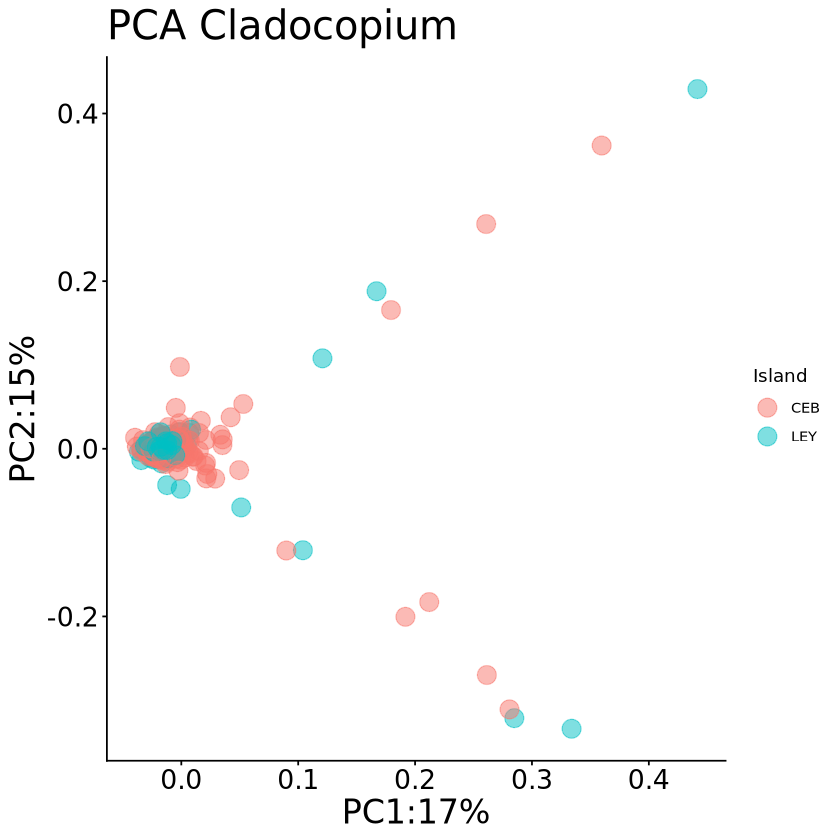

In [49]:
#Plot Cladocopium in PCA space and color by island (Cebu vs. Leyte)
ggplot(eigenvec, aes(x=PC1, y=PC2,color=Island)) + geom_point(shape=19,size=5,alpha=0.5)+
theme_classic()+
theme(plot.title = element_text(size=24),axis.text.x = element_text(size = 16),axis.text.y = element_text(size = 16),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20))+
ggtitle('PCA Cladocopium')+
labs(x="PC1:17%", y = "PC2:15%")
ggsave('Cladocopium_pca_island.png',dpi = 1200)

Saving 7 x 7 in image


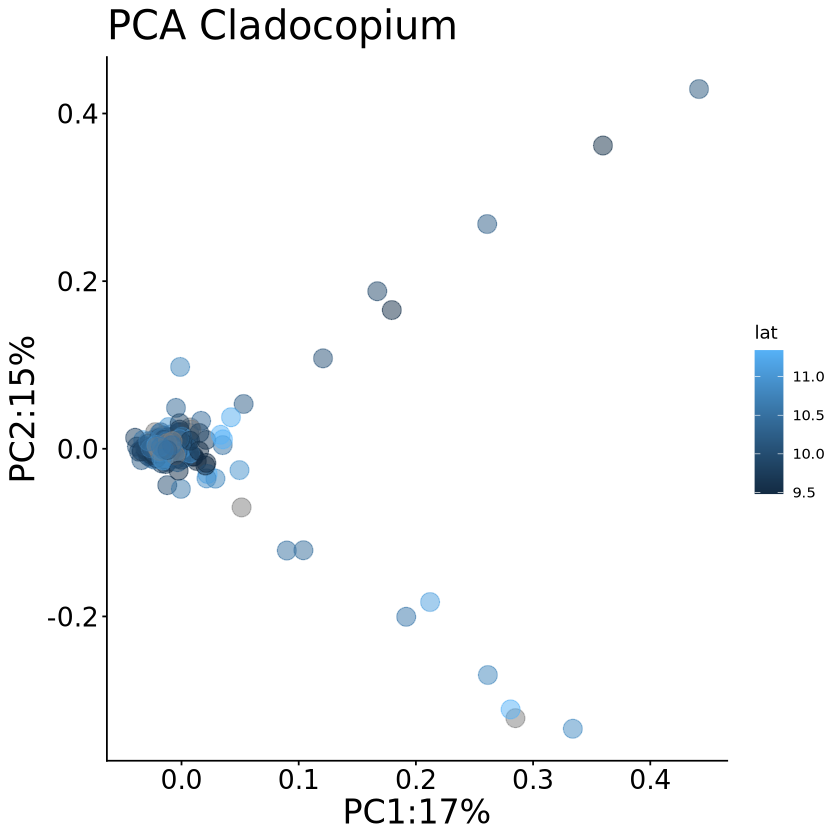

In [50]:
#Plot Cladocopium in PCA space and color by latitude
ggplot(metadat_merge, aes(x=PC1, y=PC2,color=lat)) + geom_point(shape=19,size=5,alpha=0.5)+
theme_classic()+
theme(plot.title = element_text(size=24),axis.text.x = element_text(size = 16),axis.text.y = element_text(size = 16),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20))+
ggtitle('PCA Cladocopium')+
labs(x="PC1:17%", y = "PC2:15%")
ggsave('Cladocopium_pca_lat.png',dpi = 1200)

Saving 7 x 7 in image


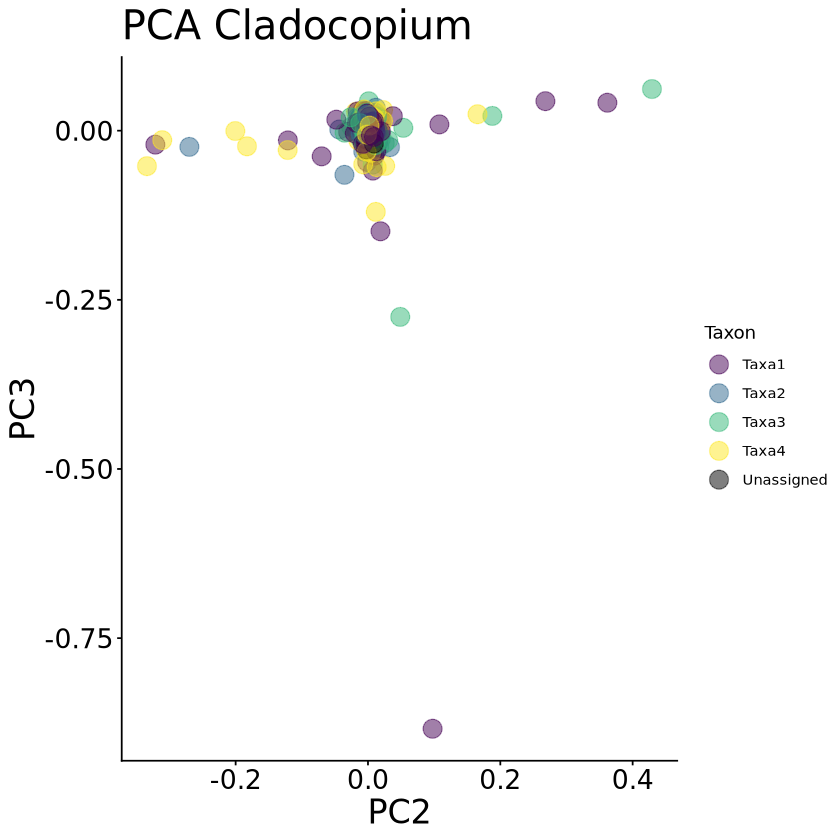

In [51]:
#Plot Cladocopium on PCs 2 and 3 and color by Acropora cryptic taxon
ggplot(metadat_merge, aes(x=PC2, y=PC3,color=Taxon)) + geom_point(shape=19,size=5,alpha=0.5)+
theme_classic()+
scale_color_manual(values = taxa_colors)+
theme(plot.title = element_text(size=24),axis.text.x = element_text(size = 16),axis.text.y = element_text(size = 16),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20))+
ggtitle('PCA Cladocopium')
ggsave('Cladocopium_pca_23.png',dpi = 1200)

In [52]:
#Make a list of individual corals in the Cladocopium dataset
inds<-as.data.frame(matrix(nrow=nrow(gi@tab),ncol=1))
inds$ind<-rownames(gi@tab)
colnames(inds)<-c('taxa','ind')

In [53]:
#Replace names with number of appropriate taxon
inds$taxa<-0
inds[inds$ind %in% taxa1,1]<-1
inds[inds$ind %in% taxa2,1]<-2
inds[inds$ind %in% taxa3,1]<-3
inds[inds$ind %in% taxa4,1]<-4

In [54]:
#Set Acropora cyptic taxon as 'population' variable within the Cladocopium genind
gi@pop<-as.factor(inds$taxa)

In [55]:
#Convert to hierfstat
hstat1<-genind2hierfstat(gi,pop=gi@pop)

In [56]:
#Calculate pairwise FSTs based on cryptic Acropora taxa
#fst_taxa<-pairwise.WCfst(hstat1)

In [57]:
#Print FSTs
fst_taxa

ERROR: Error: object 'fst_taxa' not found


In [58]:
#Check number of individuals per taxon with Cladocopium data
table(inds$taxa)


  0   1   2   3   4 
 14 113  73  49  61 

In [59]:
fst_bootstrap<- function(taxaA,taxaB,genind0,nboot=100){

#Make genind with only relevant taxa
genind_subset<-genind0[genind0@pop %in% c(taxaA,taxaB)]

boot_fsts<-c()

j=0
while (j < nboot){
	print(j)
	#Create random set of numbers length equal to number of individuals in that taxa
	len1<-as.numeric(table(genind_subset@pop)[1])
	i1<-round(runif(len1,1,nrow(genind_subset@tab)))
	len2<-as.numeric(table(genind_subset@pop)[2])
	i2<-round(runif(len2,1,nrow(genind_subset@tab)))
	#Make new dataset with those row numbers
	sample<-genind_subset[c(i1,i2),]
	sample@pop<-as.factor(c(rep('A',len1),rep('B',len2)))
	rownames(sample@tab)<-c(seq(1,nrow(sample@tab),1))
	#Convert to hierfstat
	sample_h<-genind2hierfstat(sample)
	sample_taxa<-pairwise.WCfst(sample_h)	
	boot_fsts<-c(boot_fsts,sample_taxa[2,1])
    j=j+1
}
return(boot_fsts)
}

In [60]:
genind_subset<-gi[gi@pop %in% c(1,2)]

In [61]:
boot12<-ecdf(read.csv('cladocopium12_fst_boot.csv')[,2])
boot13<-ecdf(read.csv('cladocopium13_fst_boot.csv')[,2])
boot14<-ecdf(read.csv('cladocopium14_fst_boot.csv')[,2])
boot23<-ecdf(read.csv('cladocopium23_fst_boot.csv')[,2])
boot24<-ecdf(read.csv('cladocopium24_fst_boot.csv')[,2])
boot34<-ecdf(read.csv('cladocopium34_fst_boot.csv')[,2])

In [62]:
1- boot12(fst_taxa[2,3])

ERROR: Error: object 'fst_taxa' not found


In [25]:
1- boot13(fst_taxa[2,4])

[1] 0.502

In [26]:
1- boot14(fst_taxa[2,5])

[1] 0.008

In [27]:
1- boot23(fst_taxa[3,4])

[1] 0.083

In [28]:
1- boot24(fst_taxa[3,5])

[1] 0.038

In [29]:
1- boot34(fst_taxa[4,5])

[1] 0.37